In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score


In [42]:
df = pd.read_csv('../../../datasets/parte2/treino/dataset_prepared.csv', na_filter= False)

In [43]:
lb_make = LabelEncoder()
df['injection'] = lb_make.fit_transform(df['injection'])

X = df.drop('injection', axis=1)
y = df[['injection']]

### Normalization

In [44]:
scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(X)
scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(y)
X = pd.DataFrame(scaler_X.transform(X[X.columns]), columns=X.columns)
#y = pd.DataFrame(scaler_y.transform(y[y.columns]), columns=y.columns)

In [45]:
df.head

<bound method NDFrame.head of         temp  feels_like  temp_min  temp_max  pressure  humidity  wind_speed  \
0      13.97       13.54     11.45     14.04      1027        81        1.96   
1      13.48       13.02     13.43     13.90      1028        82        1.83   
2      12.93       12.47     12.72     13.43      1027        84        1.96   
3      12.61       12.15     10.34     12.93      1027        85        1.85   
4      12.61       12.17      9.79     12.93      1027        86        1.83   
...      ...         ...       ...       ...       ...       ...         ...   
11011  15.70       15.57     15.57     15.72      1018        86        5.56   
11012  15.55       15.43     12.72     15.70      1018        87        4.47   
11013  13.45       13.28     12.23     13.99      1019        93        3.29   
11014  12.93       12.73     12.23     13.43      1019        94        1.49   
11015  12.93       12.76     12.23     13.43      1019        95        1.93   

       cl

#### Train Test Split

Now let's split the data into a training set and a testing set. We will train out model on the training set and then use the test set to evaluate the model.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2023, stratify=y)

num_classes = 5
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [47]:
def build_model(activation='relu', learning_rate=0.005, dropout_rate=0.1):
    model = Sequential()
    model.add(Dense(64, input_dim=X.shape[1], activation=activation ))
    model.add(Dropout(dropout_rate))  # Adiciona Dropout após a primeira camada densa
    model.add(Dense(32, activation=activation))
    model.add(Dropout(dropout_rate))  # Adiciona Dropout após a segunda camada densa
    model.add(Dense(5, activation='softmax')) # output 
    #Compile the model
    model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'])
    return model 

In [48]:
model = build_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                1152      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_20 (Dense)            (None, 5)                 165       
                                                                 
Total params: 3,397
Trainable params: 3,397
Non-trainable params: 0
_________________________________________________________________


In [49]:
param_grid = {
    'optimizer': ['SGD', 'RMSprop', 'Adagrad'] 
} 

In [50]:
#kf = KFold(n_splits=5, shuffle=True, random_state=2023)

In [51]:
model = KerasClassifier(model=build_model, batch_size=32, validation_split=0.2, epochs=100)

In [52]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=15, scoring='accuracy', refit=True, verbose=2, n_jobs=-1)

In [53]:
grid_search.fit(X_train, y_train)

Fitting 15 folds for each of 3 candidates, totalling 45 fits


Epoch 1/100
207/207 [==============================] - 1s 2ms/step - loss: 0.8839 - accuracy: 0.7049 - val_loss: 0.6911 - val_accuracy: 0.7223
Epoch 2/100
207/207 [==============================] - 0s 2ms/step - loss: 0.5690 - accuracy: 0.7789 - val_loss: 0.5519 - val_accuracy: 0.7719
Epoch 3/100
207/207 [==============================] - 0s 2ms/step - loss: 0.4924 - accuracy: 0.8018 - val_loss: 0.5121 - val_accuracy: 0.7943
Epoch 4/100
207/207 [==============================] - 0s 2ms/step - loss: 0.4617 - accuracy: 0.8133 - val_loss: 0.4856 - val_accuracy: 0.8004
Epoch 5/100
207/207 [==============================] - 0s 2ms/step - loss: 0.4406 - accuracy: 0.8205 - val_loss: 0.4766 - val_accuracy: 0.8040
Epoch 6/100
207/207 [==============================] - 0s 2ms/step - loss: 0.4252 - accuracy: 0.8245 - val_loss: 0.4603 - val_accuracy: 0.8076
Epoch 7/100
207/207 [==============================] - 0s 2ms/step - loss: 0.4165 - accuracy: 0.8266 - val_loss: 0.4593 - val_accuracy: 0.8016

GridSearchCV(cv=15,
             estimator=KerasClassifier(batch_size=32, epochs=100, model=<function build_model at 0x000001CDFEBDEB00>, validation_split=0.2),
             n_jobs=-1, param_grid={'optimizer': ['SGD', 'RMSprop', 'Adagrad']},
             scoring='accuracy', verbose=2)

In [54]:
best_mlp_model = grid_search.best_estimator_
print(best_mlp_model)

KerasClassifier(
	model=<function build_model at 0x000001CDFEBDEB00>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=SGD
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=100
	class_weight=None
)


In [55]:
best_mlp_model.fit(X_train, y_train, epochs=100, validation_data = (X_test, y_test), verbose = 1)

Epoch 1/100


259/259 [==============================] - 1s 2ms/step - loss: 0.8717 - accuracy: 0.7067 - val_loss: 0.6215 - val_accuracy: 0.7484
Epoch 2/100
259/259 [==============================] - 0s 2ms/step - loss: 0.5659 - accuracy: 0.7756 - val_loss: 0.4859 - val_accuracy: 0.7977
Epoch 3/100
259/259 [==============================] - 0s 2ms/step - loss: 0.4928 - accuracy: 0.7944 - val_loss: 0.4524 - val_accuracy: 0.8068
Epoch 4/100
259/259 [==============================] - 0s 2ms/step - loss: 0.4623 - accuracy: 0.8068 - val_loss: 0.4312 - val_accuracy: 0.8174
Epoch 5/100
259/259 [==============================] - 0s 2ms/step - loss: 0.4454 - accuracy: 0.8149 - val_loss: 0.4195 - val_accuracy: 0.8228
Epoch 6/100
259/259 [==============================] - 1s 2ms/step - loss: 0.4301 - accuracy: 0.8187 - val_loss: 0.4180 - val_accuracy: 0.8184
Epoch 7/100
259/259 [==============================] - 0s 2ms/step - loss: 0.4172 - accuracy: 0.8218 - val_loss: 0.4037 - val_accuracy: 0.8286
Epoch 8/100

KerasClassifier(
	model=<function build_model at 0x000001CDFEBDEB00>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=SGD
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=100
	class_weight=None
)

#### Learning Curves

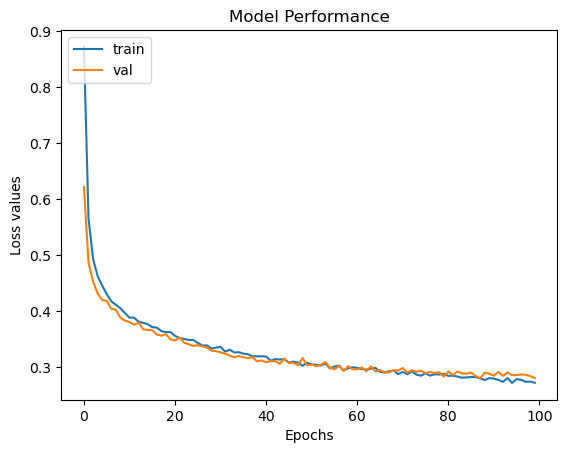

In [56]:
plt.plot(best_mlp_model.history_['loss'])
plt.plot(best_mlp_model.history_['val_loss'])
plt.title('Model Performance')
plt.ylabel('Loss values')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [57]:
predictions = best_mlp_model.predict(X_test)

87/87 [==============================] - 0s 885us/step


In [58]:
accuracy_score(y_test, predictions)

0.8848946986201888

In [59]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.72      0.63      0.67       276
           1       0.47      0.31      0.38       108
           2       0.64      0.72      0.67       274
           3       0.98      0.98      0.98      1944
           4       0.71      0.84      0.77       152

   micro avg       0.88      0.88      0.88      2754
   macro avg       0.70      0.70      0.69      2754
weighted avg       0.88      0.88      0.88      2754
 samples avg       0.88      0.88      0.88      2754



In [60]:
#df_predicoes = pd.DataFrame({'Result': predictions})
#df_predicoes['RowId'] = range(1, len(predictions) + 1)
#df_predicoes = df_predicoes[['RowId', 'Result']]

#df_predicoes.to_csv('../../../datasets/parte2/teste/neuralNetwork.csv', index=False)